setup

In [139]:
from FireSimulator import *

import copy
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
import sys
import time

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


function to visualize forest

In [2]:
def visualize_forest(axis_handle, data):
    r, c = data.shape
    for i in range(r):
        for j in range(c):
            x = col_to_x(j)
            y = row_to_y(r,i)
            
            rect = patches.Rectangle((x-0.5,y-0.5),1,1,alpha=0.6)
            
            if data[i,j] == 0:
                rect.set_color('g')
            elif data[i,j] == 1:
                rect.set_color('r')
            elif data[i,j] == 2:
                rect.set_color('k')
                
            axis_handle.add_patch(rect)
    
    return axis_handle

parameters

In [3]:
grid_size = 25
dp = 0
alpha = 0.2763
beta = np.exp(-0.1)

nn = [(-1,0),(1,0),(0,-1),(0,1)]

neighbors = {}
for i in range(grid_size):
    for j in range(grid_size):
        neighbors[(i,j)] = []
        
        for (di,dj) in nn:
            ii = i + di
            jj = j + dj
            if ii>=0 and ii<grid_size and jj>=0 and jj<grid_size:
                neighbors[(i,j)].append((ii,jj))

In [4]:
def dynamics(xi_tm1, fi_tm1, xi_t):
    if xi_tm1 == 0:
        if xi_t == 0:
            return alpha**fi_tm1
        elif xi_t == 1:
            return 1-alpha**fi_tm1
        elif xi_t == 2:
            return 0
        
    elif xi_tm1 == 1:
        if xi_t == 0:
            return 0
        elif xi_t == 1:
            return beta
        elif xi_t == 2:
            return 1-beta
        
    elif xi_tm1 == 2:
        if xi_t == 0:
            return 0
        elif xi_t == 1:
            return 0
        elif xi_t == 2:
            return 1

first case: measurement model $p(y^{t}_{t} ~|~ x^{t}_{i})$

In [72]:
meas_right = 0.9
meas_wrong = 0.5*(1-meas_right)
def measurement(xi_t, yi_t):
    if xi_t != yi_t:
        return meas_wrong
    elif xi_t == yi_t:
        return meas_right

In [277]:
def variational_method(prior, neighbors, grid_size, meas_data, Kmax=1, C=10):
    post = np.zeros_like(prior)
    #post[:,:,0] = 0.34
    #post[:,:,1] = 0.33
    #post[:,:,2] = 0.33
    
    prior_simple = np.zeros((grid_size,grid_size,2))
    prior_simple[:,:,1] = prior[:,:,1]
    prior_simple[:,:,0] = 1 - prior_simple[:,:,1]
    
    node_data = {}
    for i in range(grid_size):
        for j in range(grid_size):
            node_data[(i,j)] = {}
            
            #node_data[(i,j)]['post_simple'] = [0,0,0,0,0]
            node_data[(i,j)]['post_next'] = [0,0,0]
            
            node_data[(i,j)]['msg'] = {}
            node_data[(i,j)]['msg_simple'] = {}
            node_data[(i,j)]['msg_hat'] = {}
            node_data[(i,j)]['msg_next'] = {}
            
            node_data[(i,j)]['prior_simple'] = [0,0,0,0,0]
            
            num_neighbors = len(neighbors[(i,j)])
            for l in range(2**num_neighbors):
                xj = np.base_repr(l, base=2).zfill(num_neighbors)

                f = xj.count('1')

                p = 0
                for m in range(num_neighbors):
                    nghbr = neighbors[(i,j)][m]
                    prob = prior_simple[nghbr[0],nghbr[1],int(xj[m])]
                    if prob < 5e-5:
                        p = -50
                        break
                    else:
                        p += np.log(prob)
                    
                if p <= -50:
                    node_data[(i,j)]['prior_simple'][f] += 0
                else:
                    node_data[(i,j)]['prior_simple'][f] += np.exp(p)
    
    for iteration in range(Kmax):
        
        for i in range(grid_size):
            for j in range(grid_size):

                if iteration == 0:
        
                    for xi_tm1 in range(3):
                        for xi_t in range(3):
                            node_data[(i,j)]['msg_hat'][(xi_tm1,xi_t)] = 0
                            for fi_tm1 in range(5):
                                node_data[(i,j)]['msg_hat'][(xi_tm1,xi_t)] += \
                                    dynamics(xi_tm1, fi_tm1, xi_t)*node_data[(i,j)]['prior_simple'][fi_tm1]
                    
                    qi_list = [0,0,0]
                    for xi_t in range(3):
                        for xi_tm1 in range(3):
                            qi_list[xi_t] += prior[i,j,xi_tm1]*node_data[(i,j)]['msg_hat'][(xi_tm1,xi_t)]
                        
                        #if value <= 1e-4:
                        #    value = np.log(measurement(xi_t, meas_data[i,j])) - 10000
                        #else:
                        #    value = np.log(measurement(xi_t, meas_data[i,j])) + np.log(value)
                            
                        #value = C*(measurement(xi_t, meas_data[i,j])) + C*value #-C
                        
                        #node_data[(i,j)]['post_next'][xi_t] = np.exp(value)
                        
                        qi_list[xi_t] = C*measurement(xi_t, meas_data[i,j])*qi_list[xi_t]
                    
                    qi_list = [el-max(qi_list) for el in qi_list]
                    normalization = 0
                    for idx,el in enumerate(qi_list):
                        if el < -50:
                            qi_list[idx] = 0
                            continue

                        qi_list[idx] = np.exp(el)
                        normalization += qi_list[idx]

                    qi_list /= normalization
                    
                    #node_data[(i,j)]['post_next'] /= sum(node_data[(i,j)]['post_next']) 
                    node_data[(i,j)]['post_next'] = qi_list
                    
                    for xi_tm1 in range(3):
                        node_data[(i,j)]['msg_next'][xi_tm1] = 0  
                        for xi_t in range(3):
                            node_data[(i,j)]['msg_next'][xi_tm1] += \
                                node_data[(i,j)]['post_next'][xi_t]*node_data[(i,j)]['msg_hat'][(xi_tm1,xi_t)]
                    
                    msg_normalization = sum(node_data[(i,j)]['msg_next'].values())
                    for key in node_data[(i,j)]['msg_next'].keys():
                        node_data[(i,j)]['msg_next'][key] /= msg_normalization
                    
                else:

                    num_neighbors = len(neighbors[(i,j)])
                    
                    for idx in range(5):
                        node_data[(i,j)]['msg_simple'][idx] = 0
                    
                    for l in range(2**num_neighbors):
                        xj = np.base_repr(l, base=2).zfill(num_neighbors)

                        fi_tm1 = xj.count('1')
                        #node_data[(i,j)]['msg_simple'].setdefault(fi_tm1, 0)

                        p = 0
                        for m in range(num_neighbors):
                            nghbr = neighbors[(i,j)][m]
                            if int(xj[m]) == 0:
                                prob = (node_data[(nghbr[0],nghbr[1])]['msg'][0] + \
                                        node_data[(nghbr[0],nghbr[1])]['msg'][2])
                            elif int(xj[m]) == 1:
                                prob = node_data[(nghbr[0],nghbr[1])]['msg'][1]
                                
                            if prob < 1e-10:
                                p = -50
                                break
                            else:
                                p += np.log(prob)
                        
                        # debug
                        if p >= 10:
                            print('iteration:',iteration)
                            print('p:',p)
                            for m in range(num_neighbors):
                                nghbr = neighbors[(i,j)][m]
                                if int(xj[m]) == 0:
                                    prob = (node_data[(nghbr[0],nghbr[1])]['msg'][0] + \
                                            node_data[(nghbr[0],nghbr[1])]['msg'][2])
                                elif int(xj[m]) == 1:
                                    prob = node_data[(nghbr[0],nghbr[1])]['msg'][1]
                                
                                print(prob)
                                
                            print(node_data[(i,j)])
                            raise Exception()
                            
                        if p <= -50:
                            node_data[(i,j)]['msg_simple'][fi_tm1] += 0
                        else:
                            node_data[(i,j)]['msg_simple'][fi_tm1] += np.exp(p)
                        
                    for xi_tm1 in range(3):
                        for xi_t in range(3):
                            node_data[(i,j)]['msg_hat'][(xi_tm1,xi_t)] = 0
                            for fi_tm1 in range(5):
                                node_data[(i,j)]['msg_hat'][(xi_tm1,xi_t)] += \
                                    dynamics(xi_tm1, fi_tm1, xi_t)*node_data[(i,j)]['prior_simple'][fi_tm1]* \
                                    node_data[(i,j)]['msg_simple'][fi_tm1]      
                    
                    qi_list = [0,0,0]
                    for xi_t in range(3):
                        for xi_tm1 in range(3):
                            qi_list[xi_t] += prior[i,j,xi_tm1]*node_data[(i,j)]['msg_hat'][(xi_tm1,xi_t)]
                        
                        #if value <= 1e-4:
                        #    value = np.log(measurement(xi_t, meas_data[i,j])) - 10 
                        #else:
                        #    value = np.log(measurement(xi_t, meas_data[i,j])) + np.log(value) # - C
                            
                        #value_list[xi_t] = value
                        
                        qi_list[xi_t] = C*measurement(xi_t, meas_data[i,j])*qi_list[xi_t]
                        #if qi_list[xi_t] <= 1e-10:
                        #    qi_list[xi_t] = np.log(measurement(xi_t, meas_data[i,j])) - 50 + np.log(C)
                        #else:
                        #    qi_list[xi_t] = np.log(measurement(xi_t, meas_data[i,j])) + \
                        #                        np.log(qi_list[xi_t]) + np.log(C)
                    
                    #qi_list = [np.exp(el) for el in qi_list]
                    qi_vals = [el-max(qi_list) for el in qi_list]
                    normalization = 0
                    for idx,el in enumerate(qi_vals):
                        if el < -50:
                            qi_vals[idx] = 0 
                            continue
                        
                        qi_vals[idx] = np.exp(el)
                        normalization += qi_vals[idx]
                        
                    node_data[(i,j)]['post_next'] = qi_vals / normalization

                    #C_stable = max(value_list)
                    #C_stable = 0
                    #if sum(value_list) <= -30:
                    #    C_stable = -10
                    #for xi_t in range(3):
                    #    node_data[(i,j)]['post_next'][xi_t] = np.exp(value_list[xi_t] - C_stable)
    
                    #node_data[(i,j)]['post_next'] /= sum(node_data[(i,j)]['post_next']) 
                    
                    for xi_tm1 in range(3):
                        node_data[(i,j)]['msg_next'][xi_tm1] = 0  
                        for xi_t in range(3):
                            node_data[(i,j)]['msg_next'][xi_tm1] += node_data[(i,j)]['post_next'][xi_t]*\
                                node_data[(i,j)]['msg_hat'][(xi_tm1,xi_t)]
                                
                    msg_normalization = sum(node_data[(i,j)]['msg_next'].values())
                    for key in node_data[(i,j)]['msg_next'].keys():
                        node_data[(i,j)]['msg_next'][key] /= msg_normalization
                                
                    if any([el > 10 for el in node_data[(i,j)]['msg_next'].values()]):
                        print(qi_list)
                        print(qi_vals)
                        print(normalization)
                        print('k iteration:',iteration)
                        print('id:',(i,j))
                        print(node_data[(i,j)])
                        raise Exception()
                            
        for i in range(grid_size):
            for j in range(grid_size):
                node_data[(i,j)]['msg'] = copy.copy(node_data[(i,j)]['msg_next'])
                
                post[i,j,:] = copy.copy(node_data[(i,j)]['post_next'])
                
                node_data[(i,j)]['msg_simple'] = {}
                node_data[(i,j)]['msg_hat'] = {}
                node_data[(i,j)]['msg_next'] = {}
                node_data[(i,j)]['post_next'] = [0,0,0]

    return post, node_data

In [294]:
np.random.seed(1)

sim = FireSimulator(grid_size, alpha=alpha, beta=beta)

sim.step([], dbeta=dp)

belief = np.zeros((grid_size,grid_size,3))
idx = np.where(sim.state==0)
belief[idx[0],idx[1],:] = [1,0,0]
idx = np.where(sim.state==1)
belief[idx[0],idx[1],:] = [0,1,0]
idx = np.where(sim.state==2)
belief[idx[0],idx[1],:] = [0,0,1]

meas_data = sim.state
state_est = np.argmax(belief, axis=2) 
meas_errors = []
state_errors = []

plotting = False

if plotting:
    fig = plt.figure(figsize=(15,15))

    ax1 = fig.add_subplot(131, aspect='equal')
    ax1.set_xlim([0,grid_size+1])
    ax1.set_ylim([0,grid_size+1])
    plt.title('ground truth\nt = %d' %sim.iter)
    plt.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False, left=False)
    ax1 = visualize_forest(ax1, sim.state)

    ax2 = fig.add_subplot(132, aspect='equal')
    ax2.set_xlim([0,grid_size+1])
    ax2.set_ylim([0,grid_size+1])
    plt.title('measurement: %d error(s)\nt = %d' %(np.sum(meas_data != sim.state),sim.iter))
    plt.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False, left=False)
    ax2 = visualize_forest(ax2, meas_data)

    ax3 = fig.add_subplot(133, aspect='equal')
    ax3.set_xlim([0,grid_size+1])
    ax3.set_ylim([0,grid_size+1])
    plt.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False, left=False)
    plt.title('estimate: %d error(s)\nt = %d' %(np.sum(state_est != sim.state),sim.iter))
    ax3 = visualize_forest(ax3, state_est)
    
    rows, cols = np.where(state_est != sim.state)
    for i, j in zip(rows, cols):
        x = col_to_x(j)
        y = row_to_y(grid_size, i)
        plt.plot(x, y, marker='o', color='b')

tic = time.clock()
# for _ in range(30):
while not sim.end:
    
    sim.step([], dbeta=dp)
    
    meas_data = np.zeros_like(sim.state) + -1
    for i in range(grid_size):
        for j in range(grid_size):
            
            meas = sim.state[i,j]
            p_list = [meas_wrong,meas_wrong,meas_wrong]
            p_list[meas] += meas_right - meas_wrong
            meas_data[i,j] = np.random.choice([0,1,2], p=p_list)
    
    belief, debug = variational_method(belief, neighbors, grid_size, meas_data, Kmax=1, C=100)
    state_est = np.argmax(belief, axis=2)
    
    num_errors = np.sum(state_est != sim.state)
    state_errors.append(num_errors)
    meas_errors.append(np.sum(meas_data != sim.state))
    #print('iteration %03d: %d errors' %(sim.iter,num_errors))
    
    if plotting:
        fig = plt.figure(figsize=(15,15))

        ax1 = fig.add_subplot(131, aspect='equal')
        ax1.set_xlim([0,grid_size+1])
        ax1.set_ylim([0,grid_size+1])
        plt.title('ground truth\nt = %d' %sim.iter)
        plt.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False, left=False)
        ax1 = visualize_forest(ax1, sim.state)

        ax2 = fig.add_subplot(132, aspect='equal')
        ax2.set_xlim([0,grid_size+1])
        ax2.set_ylim([0,grid_size+1])
        plt.title('measurement: %d error(s)\nt = %d' %(np.sum(meas_data != sim.state),sim.iter))
        plt.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False, left=False)
        ax2 = visualize_forest(ax2, meas_data)

        ax3 = fig.add_subplot(133, aspect='equal')
        ax3.set_xlim([0,grid_size+1])
        ax3.set_ylim([0,grid_size+1])
        plt.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False, left=False)
        plt.title('estimate: %d error(s)\nt = %d' %(np.sum(state_est != sim.state),sim.iter))
        ax3 = visualize_forest(ax3, state_est)

        rows, cols = np.where(state_est != sim.state)
        for i, j in zip(rows, cols):
            x = col_to_x(j)
            y = row_to_y(grid_size, i)
            plt.plot(x, y, marker='o', color='b')
            
    #print('sim iteration:',sim.iter)
    
toc = time.clock()
#print('median number of errors: %0.2f' %(np.median(state_errors)))
print('median percent error: %0.3f' %(np.median(state_errors)*100/grid_size**2))
print('mean percent error: %0.3f' %(np.mean(state_errors)*100/grid_size**2))
print('max percent error: %0.3f' %(np.amax(state_errors)*100/grid_size**2))
print('min percent error: %0.3f' %(np.amin(state_errors)*100/grid_size**2))
print('%0.2fs = %0.2fm elapsed' % (toc-tic,(toc-tic)/60))

median percent error: 1.440
mean percent error: 2.826
max percent error: 9.440
min percent error: 0.000
8.20s = 0.14m elapsed


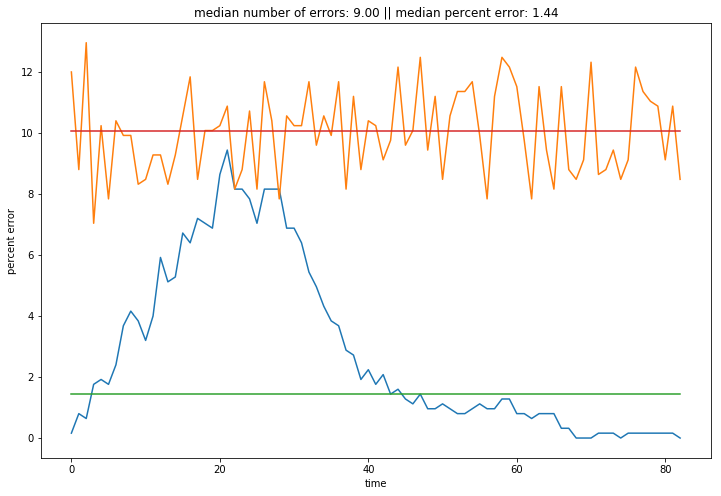

In [295]:
plot_state_errors = [100*e/grid_size**2 for e in state_errors]
plot_meas_errors = [100*e/grid_size**2 for e in meas_errors]

plt.figure(figsize=(12,8))
plt.plot(plot_state_errors)
plt.plot(plot_meas_errors)
plt.plot(range(len(plot_state_errors)),np.median(plot_state_errors)*np.ones(len(plot_state_errors)))
plt.plot(range(len(plot_meas_errors)),np.median(plot_meas_errors)*np.ones(len(plot_meas_errors)))

plt.title('median number of errors: %0.2f || median percent error: %0.2f' \
          %(np.median(state_errors),np.median(state_errors)*100/grid_size**2))
plt.ylabel('percent error')
plt.xlabel('time')

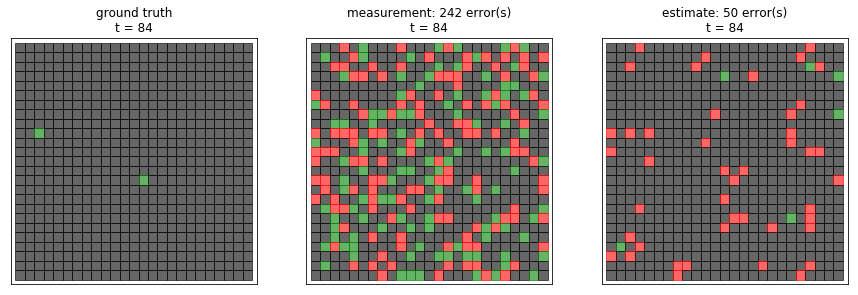

In [70]:
fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(131, aspect='equal')
ax1.set_xlim([0,grid_size+1])
ax1.set_ylim([0,grid_size+1])
plt.title('ground truth\nt = %d' %sim.iter)
plt.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False, left=False)
ax1 = visualize_forest(ax1, sim.state)

ax2 = fig.add_subplot(132, aspect='equal')
ax2.set_xlim([0,grid_size+1])
ax2.set_ylim([0,grid_size+1])
plt.title('measurement: %d error(s)\nt = %d' %(np.sum(meas_data != sim.state),sim.iter))
plt.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False, left=False)
ax2 = visualize_forest(ax2, meas_data)

ax3 = fig.add_subplot(133, aspect='equal')
ax3.set_xlim([0,grid_size+1])
ax3.set_ylim([0,grid_size+1])
plt.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False, left=False)
plt.title('estimate: %d error(s)\nt = %d' %(np.sum(state_est != sim.state),sim.iter))
ax3 = visualize_forest(ax3, state_est)

In [102]:
belief

array([[[ 0.33333333,  0.33333333,  0.33333333],
        [ 0.33333333,  0.33333333,  0.33333333],
        [ 0.33333333,  0.33333333,  0.33333333],
        ..., 
        [ 0.33333333,  0.33333333,  0.33333333],
        [ 0.33333333,  0.33333333,  0.33333333],
        [ 0.33333333,  0.33333333,  0.33333333]],

       [[ 0.33333333,  0.33333333,  0.33333333],
        [ 0.33333333,  0.33333333,  0.33333333],
        [ 0.33333333,  0.33333333,  0.33333333],
        ..., 
        [ 0.33333333,  0.33333333,  0.33333333],
        [ 0.33333333,  0.33333333,  0.33333333],
        [ 0.33333333,  0.33333333,  0.33333333]],

       [[ 0.33333333,  0.33333333,  0.33333333],
        [ 0.33333333,  0.33333333,  0.33333333],
        [ 0.33333333,  0.33333333,  0.33333333],
        ..., 
        [ 0.33333333,  0.33333333,  0.33333333],
        [ 0.33333333,  0.33333333,  0.33333333],
        [ 0.33333333,  0.33333333,  0.33333333]],

       ..., 
       [[ 0.33333333,  0.33333333,  0.33333333],
        